## Desafio de Análise de Dados: Empréstimos de Acervos das Bibliotecas da UFRN

Neste desafio do #7DaysOfCode, o objetivo é analisar os dados de empréstimos dos acervos do sistema de bibliotecas da UFRN, utilizando as ferramentas do Python como o Pandas. A partir dessa análise, será possível extrair insights valiosos sobre o comportamento dos empréstimos ao longo dos últimos anos, identificar padrões e formular hipóteses para melhorar a gestão e os processos das bibliotecas.

A análise exploratória de dados (EDA) será a principal metodologia utilizada. A EDA é fundamental para compreender as tendências nos dados, explorar informações sobre os processos, usuários e recursos das bibliotecas, além de gerar novas perguntas que podem orientar decisões mais assertivas na gestão do acervo. Durante o processo, vamos focar em questões como:

A quantidade de empréstimos tem aumentado ou diminuído ao longo dos anos?

Quais bibliotecas apresentam o maior número de empréstimos?

Quais são os temas mais e menos requisitados pelos usuários?

Para atingir esses objetivos, o trabalho será dividido em várias etapas, desde a coleta e transformação dos dados até a criação de visualizações e a exportação de tabelas para um formato utilizável em diferentes contextos. O Pandas será utilizado para importar dados de diferentes fontes, realizar transformações necessárias e, por fim, gerar insights que possam ser apresentados de forma clara e eficaz.

Com esses dados, será possível entender melhor o funcionamento do sistema de bibliotecas e fornecer informações para tomadas de decisão mais informadas, visando melhorar a experiência dos usuários e a utilização dos recursos disponíveis.


In [30]:
# Instalação das bibliotecas necessárias
%pip install pandas
%pip install fastparquet
%pip install seaborn
%pip install matplotlib
%pip install plotly
%pip install numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Coletando os dados de empréstimos (2010 a 2020)

In [61]:
anos = range(2010, 2021)
semestres = [1, 2]
arquivos = []

for ano in anos:
    for semestre in semestres:
        if ano == 2020 and semestre == 2:
            continue  # Esse arquivo não existe
        url = f"https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-{ano}{semestre}.csv?raw=true"
        try:
            df = pd.read_csv(url)
            arquivos.append(df)
        except Exception as e:
            print(f"Erro ao carregar {url}: {e}")

Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20121.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20122.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20131.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-20132.csv?raw=true: HTTP Error 429: Too Many Requests
Erro ao carregar https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/blob/main/Dia_1-Importando_dados/Datasets/dados_emprestimos/emprestimos-2014

### Concatenando os DataFrames

In [55]:
emprestimos = pd.concat(arquivos, ignore_index=True)
emprestimos.value_counts()

id_emprestimo  codigo_barras  data_renovacao                 data_emprestimo                data_devolucao                 matricula_ou_siape  tipo_vinculo_usuario  
709704         2006021442     2010/01/17 18:56:43.923000000  2010/01/04 09:58:46.522000000  2010/02/01 13:59:02.528000000  2.008010e+09        ALUNO DE GRADUAÇÃO        7
709705         2009032168     2010/01/17 18:56:43.909000000  2010/01/04 09:58:46.549000000  2010/01/20 13:14:34.464000000  2.008010e+09        ALUNO DE GRADUAÇÃO        7
709698         2009047725     2010/01/18 14:44:41.163000000  2010/01/04 09:21:19.099000000  2010/02/02 12:02:38.444000000  2.009047e+09        ALUNO DE GRADUAÇÃO        3
709686         2006017618     2010/01/26 08:07:01.738000000  2010/01/04 08:08:44.081000000  2010/02/25 07:36:25.800000000  2.008112e+09        ALUNO DE PÓS-GRADUAÇÃO    2
709687         L184117        2010/01/18 11:07:46.470000000  2010/01/04 08:24:21.284000000  2010/02/03 08:58:45.692000000  2.007211e+08        ALUNO D

### Verificando Duplicatas

In [34]:
duplicatas = emprestimos[emprestimos.duplicated()]
print(f"Total de duplicatas encontradas: {len(duplicatas)}")

Total de duplicatas encontradas: 18


### Excluindo Duplicatas

In [35]:
emprestimos = emprestimos.drop_duplicates()

In [36]:
# Exibindo as primeiras linhas do DataFrame
emprestimos.head(10)

,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario
0,709684,L095049,NaN,2010/01/04 07:44:10.721000000,2010/01/05 16:26:12.662000000,2.008023e+09,ALUNO DE GRADUAÇÃO
1,709685,L167050,NaN,2010/01/04 07:44:10.750000000,2010/01/12 07:34:13.934000000,2.008023e+09,ALUNO DE GRADUAÇÃO
2,709686,2006017618,2010/01/26 08:07:01.738000000,2010/01/04 08:08:44.081000000,2010/02/25 07:36:25.800000000,2.008112e+09,ALUNO DE PÓS-GRADUAÇÃO
3,709687,L184117,2010/01/18 11:07:46.470000000,2010/01/04 08:24:21.284000000,2010/02/03 08:58:45.692000000,2.007211e+08,ALUNO DE GRADUAÇÃO
8,709688,2007027500,2010/01/19 15:59:26.464000000,2010/01/04 08:27:33.569000000,2010/02/03 13:06:30.662000000,2.009046e+09,ALUNO DE GRADUAÇÃO
9,709689,L157395,2010/01/19 15:59:26.447000000,2010/01/04 08:27:33.596000000,2010/02/03 13:06:43.125000000,2.009046e+09,ALUNO DE GRADUAÇÃO
10,709690,2007019312,NaN,2010/01/04 08:49:57.857000000,2010/01/13 09:58:25.443000000,2.007014e+08,ALUNO DE GRADUAÇÃO
11,709691,2008046357,2010/01/19 11:50:13.404000000,2010/01/04 09:02:30.576000000,2010/02/02 12:13:36.132000000,2.005075e+08,ALUNO DE GRADUAÇÃO
12,709692,L187962,NaN,2010/01/04 09:07:06.131000000,2010/06/22 18:55:04.000000000,2.004044e+08,ALUNO DE GRADUAÇÃO
13,709693,L192776,NaN,2010/01/04 09:07:06.159000000,2010/06/22 18:54:46.000000000,2.004044e+08,ALUNO DE GRADUAÇÃO


### Importando os Dados de exemplares

In [37]:
dados_exemplares = pd.read_parquet('https://github.com/FranciscoFoz/7_Days_of_Code_Alura-Python-Pandas/raw/main/Dia_1-Importando_dados/Datasets/dados_exemplares.parquet')
dados_exemplares

,id_exemplar,codigo_barras,colecao,biblioteca,status_material,localizacao,registro_sistema
index,,,,,,,
0,5,L000003,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,694,1
1,4,L000002,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,688,1
2,3,L000001,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,638,1
3,7,L000114,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,616,5
5,10,L000041,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,657,15
...,...,...,...,...,...,...,...
568580,1353472,2021011150,Acervo Circulante,Biblioteca Setorial do Núcleo de Educação da I...,REGULAR,951,268231
568581,1353473,2019013454,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,997,268233
568582,1353474,2019012811,Acervo Circulante,Biblioteca Central Zila Mamede,ESPECIAL,987,268234


In [38]:
todos_emprestimos = emprestimos.merge(dados_exemplares, on="codigo_barras", how="inner")
todos_emprestimos.head()

,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario,id_exemplar,colecao,biblioteca,status_material,localizacao,registro_sistema
0,709684,L095049,NaN,2010/01/04 07:44:10.721000000,2010/01/05 16:26:12.662000000,2.008023e+09,ALUNO DE GRADUAÇÃO,13259,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,630,4225
1,709685,L167050,NaN,2010/01/04 07:44:10.750000000,2010/01/12 07:34:13.934000000,2.008023e+09,ALUNO DE GRADUAÇÃO,70865,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,647,25009
2,709686,2006017618,2010/01/26 08:07:01.738000000,2010/01/04 08:08:44.081000000,2010/02/25 07:36:25.800000000,2.008112e+09,ALUNO DE PÓS-GRADUAÇÃO,195347,Acervo Circulante,Biblioteca Setorial Prof. Rodolfo Helinski - E...,REGULAR,640,75019
3,709687,L184117,2010/01/18 11:07:46.470000000,2010/01/04 08:24:21.284000000,2010/02/03 08:58:45.692000000,2.007211e+08,ALUNO DE GRADUAÇÃO,131639,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,609,44494
4,709688,2007027500,2010/01/19 15:59:26.464000000,2010/01/04 08:27:33.569000000,2010/02/03 13:06:30.662000000,2.009046e+09,ALUNO DE GRADUAÇÃO,225646,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,686,91736


### Verificando a estrutura do DataFrame

In [39]:
todos_emprestimos.dtypes

id_emprestimo             int64
codigo_barras            object
data_renovacao           object
data_emprestimo          object
data_devolucao           object
matricula_ou_siape      float64
tipo_vinculo_usuario     object
id_exemplar               int64
colecao                  object
biblioteca               object
status_material          object
localizacao               int64
registro_sistema          int64
dtype: object

### Criando a coluna "CDU" com base na classificação da localização


In [40]:
def classificar_CDU(valor):
    if valor < 100:
        return 'Generalidades, Ciência e Conhecimento'
    elif valor < 200:
        return 'Filosofia e Psicologia'
    elif valor < 300:
        return 'Religião'
    elif valor < 400:
        return 'Ciências sociais'
    elif valor < 500:
        return 'Classe vaga'
    elif valor < 600:
        return 'Matemática e Ciências Naturais'
    elif valor < 700:
        return 'Ciências aplicadas'
    elif valor < 800:
        return 'Belas Artes'
    elif valor < 900:
        return 'Linguagem'
    else:
        return 'Geografia, Biografia e História'

todos_emprestimos['CDU'] = todos_emprestimos['localizacao'].apply(classificar_CDU)
todos_emprestimos.head()


,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario,id_exemplar,colecao,biblioteca,status_material,localizacao,registro_sistema,CDU
0,709684,L095049,NaN,2010/01/04 07:44:10.721000000,2010/01/05 16:26:12.662000000,2.008023e+09,ALUNO DE GRADUAÇÃO,13259,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,630,4225,Ciências aplicadas
1,709685,L167050,NaN,2010/01/04 07:44:10.750000000,2010/01/12 07:34:13.934000000,2.008023e+09,ALUNO DE GRADUAÇÃO,70865,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,647,25009,Ciências aplicadas
2,709686,2006017618,2010/01/26 08:07:01.738000000,2010/01/04 08:08:44.081000000,2010/02/25 07:36:25.800000000,2.008112e+09,ALUNO DE PÓS-GRADUAÇÃO,195347,Acervo Circulante,Biblioteca Setorial Prof. Rodolfo Helinski - E...,REGULAR,640,75019,Ciências aplicadas
3,709687,L184117,2010/01/18 11:07:46.470000000,2010/01/04 08:24:21.284000000,2010/02/03 08:58:45.692000000,2.007211e+08,ALUNO DE GRADUAÇÃO,131639,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,609,44494,Ciências aplicadas
4,709688,2007027500,2010/01/19 15:59:26.464000000,2010/01/04 08:27:33.569000000,2010/02/03 13:06:30.662000000,2.009046e+09,ALUNO DE GRADUAÇÃO,225646,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,686,91736,Ciências aplicadas


### Excluindo a coluna "registro_sistema" do DataFrame

In [41]:
todos_emprestimos.drop('registro_sistema', axis=1, inplace=True)
todos_emprestimos.columns

Index(['id_emprestimo', 'codigo_barras', 'data_renovacao', 'data_emprestimo',
       'data_devolucao', 'matricula_ou_siape', 'tipo_vinculo_usuario',
       'id_exemplar', 'colecao', 'biblioteca', 'status_material',
       'localizacao', 'CDU'],
      dtype='object')

### Transformando a coluna "matricula_ou_siape" para o tipo string

In [42]:
todos_emprestimos['matricula_ou_siape'] = todos_emprestimos['matricula_ou_siape'].astype(str)
todos_emprestimos['matricula_ou_siape'].dtypes

dtype('O')

### Relação entre empréstimo e empréstimo de exemplar

In [43]:
todos_emprestimos['id_emprestimo'].value_counts()

id_emprestimo
736107     2
748923     2
754040     2
753572     2
877824     2
          ..
1149744    1
1149745    1
1149746    1
1149747    1
1149748    1
Name: count, Length: 357484, dtype: int64

### Total de empréstimos e empréstimo de exemplares

In [44]:
qtd_emprestimos = todos_emprestimos['id_emprestimo'].nunique()
print(f"Quantidade total de empréstimos: {qtd_emprestimos}")
qtd_exemplares = len(todos_emprestimos)
print(f"Quantidade total de exemplares: {qtd_exemplares}")

Quantidade total de empréstimos: 357484
Quantidade total de exemplares: 357784


### Total de exemplares emprestados por ano

In [45]:
data_emprestimos = pd.DataFrame(todos_emprestimos['data_emprestimo'].value_counts()).reset_index()
data_emprestimos.columns = ['data','quantidade']
data_emprestimos['data'] = pd.to_datetime(data_emprestimos['data'])
data_emprestimos

,data,quantidade
0,2010-08-16 09:54:49.004,2
1,2010-07-23 16:45:20.340,2
2,2010-06-21 08:07:14.433,2
3,2010-08-23 17:05:05.130,2
4,2011-02-21 11:47:08.402,2
...,...,...
357471,2011-12-30 17:38:05.838,1
357472,2011-12-30 17:42:51.232,1
357473,2011-12-30 17:42:51.274,1
357474,2011-12-30 17:46:47.021,1


### Funções para agrupar por período e plotar o gráfico

In [ ]:
def agrupar_por_periodo(df, coluna_data, coluna_valor, periodo):
    """
    Agrupa os dados por um período específico (mês, ano ou hora) e retorna a soma dos valores.
    :param df: DataFrame com os dados.
    :param coluna_data: Nome da coluna com as datas.
    :param coluna_valor: Nome da coluna com os valores a serem somados.
    :param periodo: Período para agrupar ('month', 'year' ou 'hour').
    :return: DataFrame agrupado com a soma dos valores.
    """

    if not pd.api.types.is_datetime64_any_dtype(df[coluna_data]):
        df = df.copy()
        df[coluna_data] = pd.to_datetime(df[coluna_data])
    
    if periodo == 'month':
        resultado = df.groupby(df[coluna_data].dt.month)[coluna_valor].sum()
        meses = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'Mai', 6:'Jun', 
                7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}
        resultado.index = resultado.index.map(meses)
        resultado.index.name = 'mês'
    elif periodo == 'year':
        resultado = df.groupby(df[coluna_data].dt.year)[coluna_valor].sum()
        resultado.index.name = 'anos'
    elif periodo == 'hour':
        resultado = df.groupby(df[coluna_data].dt.hour)[coluna_valor].sum()
        resultado.index = [f"{h:02d}h" for h in resultado.index]
        resultado.index.name = 'hora'
    
    return resultado


def plotar_grafico(dados, titulo, tipo='line'):
    """
    Plota um gráfico com os dados fornecidos.
    :param dados: Dados a serem plotados (DataFrame ou Series).
    :param titulo: Título do gráfico.
    :param tipo: Tipo de gráfico ('line' ou 'bar').
    :return: Objeto do gráfico.
    """
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if tipo == 'line':
        sns.lineplot(x=dados.index, y=dados.values, marker='o', linewidth=2, color='#1f77b4', ax=ax)          
    else:
        sns.barplot(x=dados.index, y=dados.values, hue=dados.index, palette='colorblind', ax=ax, legend=False)

    
    if dados.index.name == 'anos':
        ax.set_xticks(dados.index)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(titulo, fontsize=14, fontweight='bold')
        
    elif dados.index.name == 'mês':
        ax.set_xticks(range(len(dados.index)))
        ax.set_xticklabels(dados.index, rotation=45, ha='right')
        ax.set_title(titulo, fontsize=14, fontweight='bold')

    else:
        ax.set_xticks(range(len(dados.index)))
        ax.set_title(titulo, fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    return fig, ax        


In [ ]:
agrupar_por_periodo(todos_emprestimos, 'data_emprestimo', 'id_emprestimo', 'month').head(10)

### Análise por ano

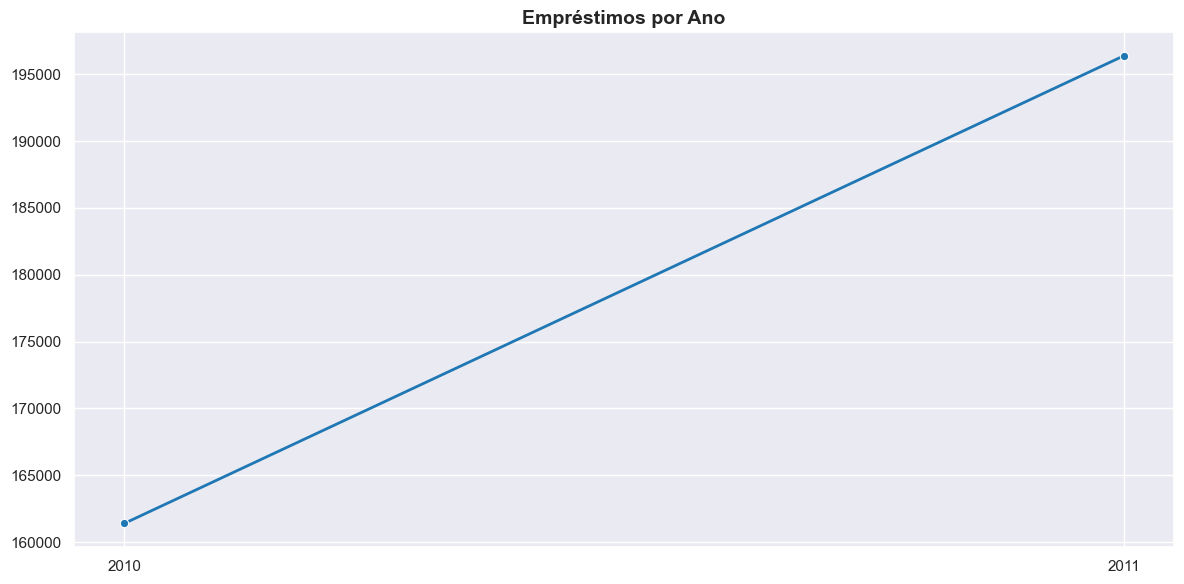

In [47]:
emprestimo_ano = agrupar_por_periodo(data_emprestimos, 'data', 'quantidade', 'year')
fig_ano, ax_ano = plotar_grafico(emprestimo_ano, 'Empréstimos por Ano', tipo='line')


A análise mostra que desde 2013 o número de exemplares emprestados vem diminuindo de forma contínua, com uma queda significativa já em 2019. O gráfico mostra que, após o pico de mais de 230 mil empréstimos em 2013, houve uma leve redução em 2014, certa estabilidade até 2017, e então uma queda mais acentuada em 2018 e 2019. Já o ano de 2020 apresentou uma quantidade de empréstimos muito inferior aos anos anteriores, mas não pode ser avaliado da mesma forma devido à diferença no volume de dados disponíveis para esse período.

É importante que a direção da biblioteca investigue com mais profundidade o que está ocorrendo desde 2013, revisando os procedimentos e buscando entender os fatores que contribuíram para essa redução. Algumas perguntas importantes que podem orientar análises futuras:

* O número de alunos da universidade vem diminuindo?

* A biblioteca está aplicando alguma pesquisa de satisfação com os usuários? Como estão os resultados?

* O acervo está atualizado e atrativo para os estudantes e pesquisadores?

* Quais estratégias de divulgação e marketing estão sendo realizadas para incentivar o uso da biblioteca?

* O que ocorreu de diferente em 2017 em comparação com 2015 e 2016, que pode ter contribuído para uma leve recuperação nos números?

*E em 2019? Houve alguma mudança estrutural, de política ou de atendimento?

### Análise por mês

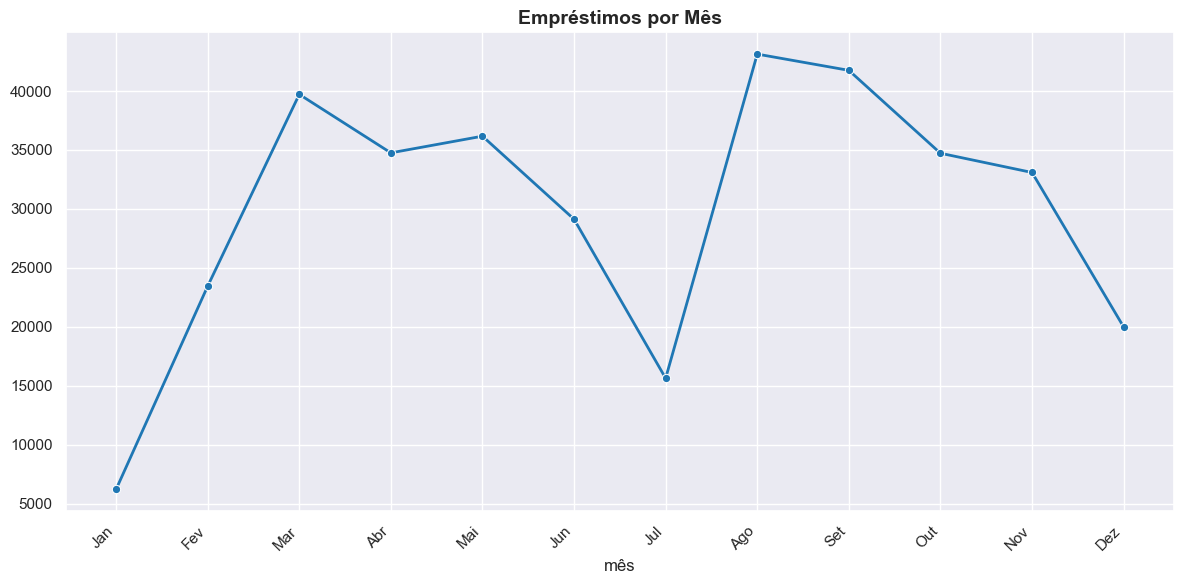

In [48]:
emprestimo_mes = agrupar_por_periodo(data_emprestimos , 'data', 'quantidade', 'month')
fig_mes, ax_mes = plotar_grafico(emprestimo_mes, 'Empréstimos por Mês', tipo='line')

Nota-se que os maiores volumes de empréstimos acontecem nos meses de março e agosto, o que faz bastante sentido considerando que são meses de início de semestre nas universidades.

Já os meses de janeiro, julho e dezembro apresentam os menores números, o que provavelmente está relacionado às férias acadêmicas. Isso não surpreende, mas é importante considerar que mesmo nesses períodos o funcionamento da biblioteca precisa ser garantido. Por isso, é essencial pensar no revezamento das equipes, evitando que todos tirem férias ao mesmo tempo, especialmente em janeiro, quando podem ser feitas atividades como inventário do acervo ou manutenção geral.

Os meses de maio, junho, outubro e novembro, que têm movimentação intermediária, podem ser bem aproveitados pela gestão para treinamentos, eventos internos ou pequenas reformas, sem impactar tanto o fluxo de usuários.

Chama atenção a queda expressiva em junho, o que merece uma investigação mais aprofundada. Pode haver algum fator pontual interferindo, como greves, calendário acadêmico alterado ou mesmo eventos que diminuem o interesse pelo uso da biblioteca nesse período.

Uma boa sugestão seria planejar ações específicas de incentivo ao uso da biblioteca antes das férias, como campanhas para empréstimo de livros para leitura em casa, desafios de leitura ou até divulgação especial nas redes sociais.

Essas ações podem ajudar a equilibrar o fluxo ao longo do ano e manter a biblioteca sempre presente na rotina dos estudantes.

### Análise por hora

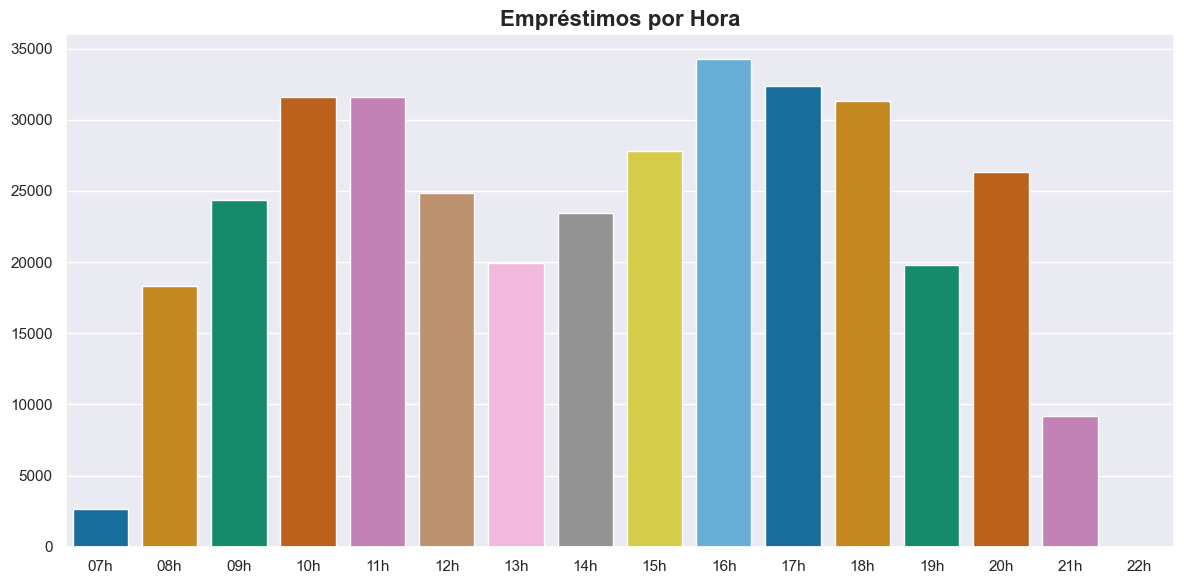

In [49]:
emprestimo_hora = agrupar_por_periodo(data_emprestimos, 'data', 'quantidade', 'hour')
fig_hora, ax_hora = plotar_grafico(emprestimo_hora, 'Empréstimos por Hora', tipo='bar')

Baseado no gráfico, vejo que há um pico significativo no atendimento de empréstimos durante as 10 h e 16 h, que são os horários de maior demanda. Isso indica que esses períodos podem exigir mais pessoal ou recursos para lidar com a demanda intensa. Além disso, pode ser interessante focar na melhoria do processo de atendimento nesses horários de pico para otimizar a eficiência.

Por outro lado, os períodos mais tranquilos, entre 7h e 9h da manhã e 19h a 22h, são ideais para realizar atividades que não dependem tanto da interação direta com os clientes, como atualização de registros, organização dos empréstimos ou planejamento das próximas etapas. Aproveitar esses horários de menor movimento pode ajudar a manter o fluxo de trabalho equilibrado ao longo do dia e garantir que as operações se mantenham eficientes.

### Analisando variáveis categóricas

Agora vamos analisar as variáveis categóricas do conjunto de dados de empréstimos da biblioteca. A ideia é entender melhor o comportamento dos usuários a partir de categorias como tipo de vínculo, coleção, biblioteca e classificação geral da CDU.

Criei uma função para gerar tabelas de frequência e percentual dessas variáveis, facilitando a visualização dos dados e a comparação entre elas. Com base nos resultados, surgem insights importantes para a diretoria: como se distribuem os empréstimos entre os tipos de vínculo, quais coleções são mais procuradas, quais bibliotecas têm mais movimentação e quais temas da CDU são mais emprestados.

Essas análises ajudam a direcionar ações, avaliar estratégias atuais e identificar oportunidades de melhoria na gestão do acervo e no atendimento ao público.

### Verificando os valores unicos 

In [50]:
todos_emprestimos.head()

,id_emprestimo,codigo_barras,data_renovacao,data_emprestimo,data_devolucao,matricula_ou_siape,tipo_vinculo_usuario,id_exemplar,colecao,biblioteca,status_material,localizacao,CDU
0,709684,L095049,NaN,2010/01/04 07:44:10.721000000,2010/01/05 16:26:12.662000000,2008023265.0,ALUNO DE GRADUAÇÃO,13259,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,630,Ciências aplicadas
1,709685,L167050,NaN,2010/01/04 07:44:10.750000000,2010/01/12 07:34:13.934000000,2008023265.0,ALUNO DE GRADUAÇÃO,70865,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,647,Ciências aplicadas
2,709686,2006017618,2010/01/26 08:07:01.738000000,2010/01/04 08:08:44.081000000,2010/02/25 07:36:25.800000000,2008112114.0,ALUNO DE PÓS-GRADUAÇÃO,195347,Acervo Circulante,Biblioteca Setorial Prof. Rodolfo Helinski - E...,REGULAR,640,Ciências aplicadas
3,709687,L184117,2010/01/18 11:07:46.470000000,2010/01/04 08:24:21.284000000,2010/02/03 08:58:45.692000000,200721119.0,ALUNO DE GRADUAÇÃO,131639,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,609,Ciências aplicadas
4,709688,2007027500,2010/01/19 15:59:26.464000000,2010/01/04 08:27:33.569000000,2010/02/03 13:06:30.662000000,2009045971.0,ALUNO DE GRADUAÇÃO,225646,Acervo Circulante,Biblioteca Central Zila Mamede,REGULAR,686,Ciências aplicadas


In [ ]:
# Valores únicos para tipo de vínculo do usuário
print("TIPO_VINCULO_USUARIO")
print(todos_emprestimos.tipo_vinculo_usuario.unique())
print("Total:", len(todos_emprestimos.tipo_vinculo_usuario.unique()))

# Valores únicos para coleção
print("\nCOLECAO")
print(todos_emprestimos.colecao.unique())
print("Total:", len(todos_emprestimos.colecao.unique()))

# Valores únicos para biblioteca
print("\nBIBLIOTECA")
print(todos_emprestimos.biblioteca.unique())
print("Total:", len(todos_emprestimos.biblioteca.unique()))

# Valores únicos para CDU
print("\nCDU")
print(todos_emprestimos.CDU.unique())
print("Total:", len(todos_emprestimos.CDU.unique()))

TIPO_VINCULO_USUARIO - valores únicos:
['ALUNO DE GRADUAÇÃO' 'ALUNO DE PÓS-GRADUAÇÃO' 'DOCENTE'
 'SERVIDOR TÉCNICO-ADMINISTRATIVO' 'DOCENTE EXTERNO' 'ALUNO MÉDIO/TÉCNICO'
 'USUÁRIO EXTERNO' 'OUTROS']
Total: 8

COLECAO - valores únicos:
['Acervo Circulante' 'Folhetos' 'Teses' 'Dissertações' 'Monografias'
 'Publicações de Autores do RN' 'Publicações da UFRN' 'Multimeios'
 'Coleção Mossoroense' 'Eventos' 'Trabalho Acadêmico'
 'Obras de Referência' 'Obras Raras' 'Literatura de Cordel'
 'Coleção Zila Mamede' 'Necessidades Educacionais Específicas']
Total: 16

BIBLIOTECA - valores únicos:
['Biblioteca Central Zila Mamede'
 'Biblioteca Setorial Prof. Rodolfo Helinski - Escola Agrícola de Jundiaí - EAJ  - Macaiba'
 'Biblioteca Setorial Bertha Cruz Enders - \xadEscola de Saúde da UFRN - ESUFRN'
 'Biblioteca Setorial do Centro Ciências da Saúde - CCS'
 'Biblioteca Setorial Prof. Alberto Moreira Campos - \xadDepartamento de Odontologia'
 'Biblioteca Setorial Prof. Ronaldo Xavier de Arruda - CCET'

### Função para gerar tabela de contagem de frequência

In [ ]:
def tabela_frequencia(df, variavel):
  '''
  Esta função gera uma tabela de frequência com percentuais de acordo 
  com a variável categórica passada.
  :param df: DataFrame com os dados.
  :param variavel: Nome da variável categórica a ser analisada.
  :return: DataFrame com a tabela de frequência e percentuais.
  
  '''


  dataframe = pd.DataFrame(df[variavel].value_counts())                      
  dataframe.columns = ['quantidade']
  dataframe['percentual'] = round((dataframe.quantidade / dataframe.quantidade.sum())*100, 1)

  return dataframe

### Frequência por tipo de vinculo do usuário

In [53]:
tabela_frequencia(todos_emprestimos, 'tipo_vinculo_usuario')

,quantidade,percentual
tipo_vinculo_usuario,,
ALUNO DE GRADUAÇÃO,286125,80.0
ALUNO DE PÓS-GRADUAÇÃO,50070,14.0
DOCENTE,11940,3.3
SERVIDOR TÉCNICO-ADMINISTRATIVO,6220,1.7
ALUNO MÉDIO/TÉCNICO,2177,0.6
DOCENTE EXTERNO,840,0.2
USUÁRIO EXTERNO,407,0.1
OUTROS,5,0.0


Com base na distribuição dos empréstimos por tipo de vínculo, podemos perceber que o aluno de graduação é, de longe, o principal usuário da biblioteca, representando 77,8% do total de empréstimos. Isso mostra que a biblioteca está muito conectada com a rotina dos cursos de graduação, o que é positivo, mas também indica onde está a maior demanda e, portanto, onde o serviço precisa ser mais robusto. 
Os alunos de pós-graduação aparecem em segundo lugar com 14,6%, o que reforça a importância de manter acervos atualizados e especializados para esse público.

### Frequência por coleção

In [59]:
tabela_frequencia(todos_emprestimos, 'colecao')

,quantidade,percentual
colecao,,
Acervo Circulante,352869,98.6
Multimeios,1862,0.5
Monografias,1196,0.3
Dissertações,775,0.2
Publicações de Autores do RN,285,0.1
Teses,285,0.1
Publicações da UFRN,204,0.1
Obras de Referência,122,0.0
Folhetos,75,0.0


Ao analisar a distribuição dos empréstimos por tipo de coleção, fica evidente que o Acervo Circulante domina amplamente, representando 99,1% de todos os empréstimos. Isso mostra que ele é o principal recurso utilizado pelos usuários, o que levanta um alerta sobre o baixo uso das demais coleções.

Coleções relevantes para a pesquisa acadêmica, como monografias (0,2%), dissertações (0,1%) e teses (0,0%), têm participação mínima nos empréstimos. Isso pode indicar um potencial pouco explorado para o fortalecimento da cultura científica e investigativa na universidade. No entanto, é importante verificar se esses materiais estão disponíveis online, o que justificaria o baixo número de empréstimos físicos.

Além disso, coleções especiais como a Coleção Mossoroense, Coleção Zila Mamede, Literatura de Cordel e Obras Raras apresentam números extremamente baixos de empréstimos. Essas coleções, por seu valor histórico, cultural ou regional, merecem atenção especial. É preciso entender se a baixa procura se deve à falta de divulgação, restrições de acesso ou desconhecimento do acervo.

### Frequência por blibliotecas

In [60]:
tabela_frequencia(todos_emprestimos, 'biblioteca')

,quantidade,percentual
biblioteca,,
Biblioteca Central Zila Mamede,266769,74.6
Biblioteca Setorial do Centro Ciências da Saúde - CCS,30054,8.4
Biblioteca Setorial Prof. Alberto Moreira Campos - ­Departamento de Odontologia,11649,3.3
Biblioteca Setorial Bertha Cruz Enders - ­Escola de Saúde da UFRN - ESUFRN,10935,3.1
"Biblioteca Setorial do Centro de Ciências Humanas, Letras e Artes - CCHLA",9456,2.6
Biblioteca Setorial Prof. Francisco Gurgel De Azevedo - Instituto Química - IQ,5972,1.7
Biblioteca Setorial Prof. Ronaldo Xavier de Arruda - CCET,5319,1.5
Biblioteca Setorial da Faculdade de Ciências da Saúde do Trairi - FACISA - Santa Cruz,4245,1.2
Biblioteca Setorial Pe. Jaime Diniz - Escola de Música - EMUFRN,3141,0.9


Como já era esperado, a Biblioteca Central Zila Mamede se destaca com folga, representando quase 69% de todos os empréstimos do sistema. Isso reflete seu porte, localização e acervo mais diversificado, sendo o principal ponto de apoio da comunidade acadêmica.

Apesar disso, é interessante ver que outras bibliotecas setoriais também têm participação significativa, como a do CCS, FACISA (Santa Cruz) e o Departamento de Odontologia, o que mostra que essas unidades têm papel relevante dentro dos seus contextos específicos.

Esse ranking é útil para visualizar o panorama geral do sistema de bibliotecas, mas só os números absolutos não contam toda a história. Para uma análise mais justa e completa, o ideal seria cruzar com outras métricas, como:

- Quantos empréstimos por usuário cadastrado cada biblioteca realiza

- Qual seria o volume esperado de empréstimos, considerando o público atendido

- Quais ações e investimentos têm sido feitos em cada unidade

Essas comparações ajudam a entender melhor onde o sistema está funcionando bem, onde há espaço para melhorias e como distribuir melhor os recursos e estratégias de incentivo ao uso das bibliotecas.

### Frequência pela CDU

In [62]:
tabela_frequencia(todos_emprestimos, 'CDU')

,quantidade,percentual
CDU,,
Ciências aplicadas,355803,99.4
Ciências sociais,1279,0.4
"Geografia, Biografia e História",124,0.0
Matemática e Ciências Naturais,122,0.0
Linguagem,116,0.0
"Generalidades, Ciência e Conhecimento",95,0.0
Belas Artes,90,0.0
Filosofia e Psicologia,88,0.0
Religião,67,0.0


De maneira geral, dá pra ver uma diferença bem grande entre os temas. A categoria Ciências Aplicadas domina com quase 69% dos empréstimos, o que mostra que o acervo e o interesse dos usuários estão muito voltados para áreas mais práticas e aplicadas, como saúde, engenharia e tecnologia. Em seguida, Ciências Sociais também tem um bom volume, com 17,8%, o que é esperado, já que muitas graduações e pesquisas orbitam essas áreas.

Por outro lado, temas como Geografia/Biografia/História, Belas Artes e Linguagem aparecem com números bem baixos (menos de 0,5% cada), o que chama atenção e levanta algumas questões:

- O acervo desses temas está atualizado ou está defasado?

- Esses temas atendem às necessidades do público atual da biblioteca?

- Está sendo feita alguma ação de divulgação ou incentivo para o uso desses materiais?

Pode ser que esses conteúdos estejam esquecidos, mal localizados ou pouco promovidos. Vale a pena a direção avaliar se é uma questão de falta de interesse do público ou de visibilidade do acervo. Uma ideia seria fazer campanhas temáticas ou destacar obras dessas áreas em períodos estratégicos, como durante eventos acadêmicos ou datas comemorativas. Também pode ser útil conversar com professores dessas áreas para entender se os alunos realmente têm procurado esse tipo de material ou se estão usando outras fontes.